In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
#Creating dataframe from json data
import pandas as pd


data = [
{"app": "A", "bid_price": 0.01, "win": 0, "events": 100000}, 
{"app": "A", "bid_price": 0.01, "win": 1, "events": 0}, 
{"app": "A", "bid_price": 0.1, "win": 0, "events": 7000}, 
{"app": "A", "bid_price": 0.1, "win": 1, "events": 3000}, 
{"app": "A", "bid_price": 0.2, "win": 0, "events": 8000000}, 
{"app": "A", "bid_price": 0.2, "win": 1, "events": 2000000}, 
{"app": "A", "bid_price": 0.4, "win": 0, "events": 700000}, 
{"app": "A", "bid_price": 0.4, "win": 1, "events": 300000}, 
{"app": "A", "bid_price": 0.5, "win": 0, "events": 80000}, 
{"app": "A", "bid_price": 0.5, "win": 1, "events": 20000}, 
{"app": "A", "bid_price": 0.75, "win": 0, "events": 7000}, 
{"app": "A", "bid_price": 0.75, "win": 1, "events": 3000}, 
{"app": "A", "bid_price": 1, "win": 0, "events": 400}, 
{"app": "A", "bid_price": 1, "win": 1, "events": 600}, 
{"app": "A", "bid_price": 2, "win": 0, "events": 30}, 
{"app": "A", "bid_price": 2, "win": 1, "events": 70}, 
{"app": "A", "bid_price": 5, "win": 0, "events": 2}, 
{"app": "A", "bid_price": 5, "win": 1, "events": 8}, 
{"app": "A", "bid_price": 9, "win": 0, "events": 0}, 
{"app": "A", "bid_price": 9, "win": 1, "events": 1}
]

df = pd.DataFrame(data)
df.head(10)

,app,bid_price,win,events
0,A,0.01,0,100000
1,A,0.01,1,0
2,A,0.10,0,7000
3,A,0.10,1,3000
4,A,0.20,0,8000000
5,A,0.20,1,2000000
6,A,0.40,0,700000
7,A,0.40,1,300000
8,A,0.50,0,80000
9,A,0.50,1,20000


In [3]:
# Group by bid_price and calculate win probability
df_summary = df.groupby("bid_price").apply(
    lambda x: pd.Series({
        "total_events": x["events"].sum(),
        "win_events": x.loc[x["win"] == 1, "events"].sum(),
        "win_rate": x.loc[x["win"] == 1, "events"].sum() / x["events"].sum()
    })
).reset_index()

# Display the result
print(df_summary)

   bid_price  total_events  win_events  win_rate
0       0.01      100000.0         0.0       0.0
1       0.10       10000.0      3000.0       0.3
2       0.20    10000000.0   2000000.0       0.2
3       0.40     1000000.0    300000.0       0.3
4       0.50      100000.0     20000.0       0.2
5       0.75       10000.0      3000.0       0.3
6       1.00        1000.0       600.0       0.6
7       2.00         100.0        70.0       0.7
8       5.00          10.0         8.0       0.8
9       9.00           1.0         1.0       1.0


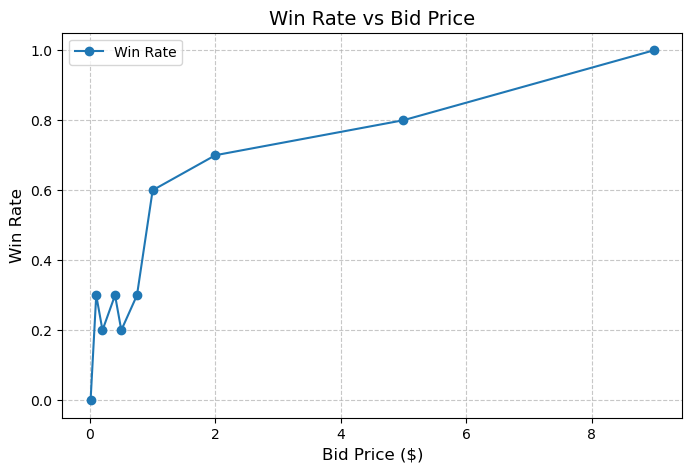

In [4]:
import matplotlib.pyplot as plt

win_data = df[df["win"] == 1].copy()
win_data["win_rate"] = win_data["events"] / df.groupby("bid_price")["events"].transform("sum")

# Plot win rate vs bid price
plt.figure(figsize=(8, 5))
plt.plot(win_data["bid_price"], win_data["win_rate"], marker='o', label='Win Rate')
plt.title("Win Rate vs Bid Price", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Here we observe that for bid price <=0.75 the win rate trend isn't following increasing trend as it should for the auction, so I fit a Linear Regression model on these noise points till bid price value 0.75 to make the data noise free for estimation of win rates.

#### Noise Points

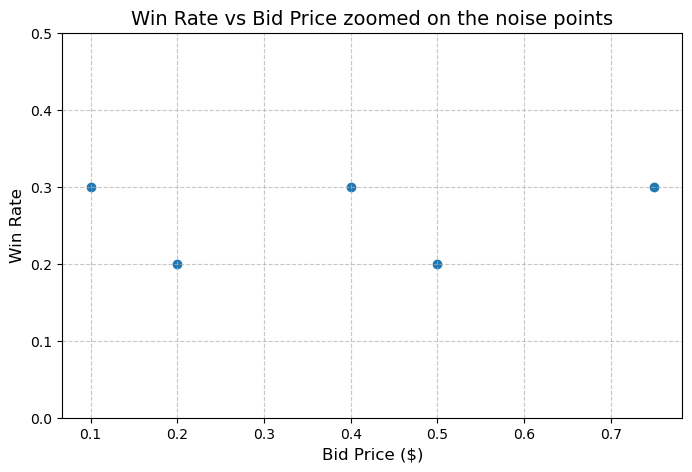

In [16]:

win_data = df[df["win"] == 1].copy()
win_data["win_rate"] = win_data["events"] / df.groupby("bid_price")["events"].transform("sum")
filtered_win_data = win_data[(win_data["bid_price"] > 0.01) & (win_data["bid_price"] <= 0.75)]


# Plot win rate vs bid price
plt.figure(figsize=(8, 5))
plt.scatter(filtered_win_data["bid_price"], filtered_win_data["win_rate"], marker='o', label='Win Rate')
plt.title("Win Rate vs Bid Price zoomed on the noise points", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.ylim(0, 0.5)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend()
plt.show()

### Lets start with stating my assumptions for the calculations:
1. I assumed each bid price is an auction or you can have one bid price for an auction.
2. All other factors for a bid price like ad slot placement, dimensions or brand/advertiser can be assumed to be same for a bid price.
3. I am making the assumption that there are no errors in the notification system due to overload or high number of requests being captured which could cause a win to not be notified, so for all **no notifications** its not a win.
4. The floor price of the auction is somewhere between 0.01 and 0.1, which means 0.01 bid price is never going to win an auction (as it might be the floor price), we can exclude it for our predictions.
5. Every event is equally important, I assumed all of the bids were tested around the same time (like an A/B test), but there are events that do not follow the first price auction trend, I assumed those are noise points and fit them using a Linear Regression model.

### Steps for getting the answer
1. For each bid price I used group by to consider events for each bid price and calculate win rate by dividing the **win events** by **total events for the bid price**.
2. I used pandas to create dataframe and group by bid price column.
3. Then, I divided number of events with 'win' field value = 1 divided by events with 'win' value 1 + 'win' value 0 (i.e. total events for the bid price).
4. After plotting the win rates calculated with the above formula, we observe win rates not going up with bid price as expected and we made the assumption that all other factors are same, so it might be statistical noise and I tried to fit a Linear Regression model on the noise points.
5. For bid price 0.75 or higher the win probability increases with increase in bid price, so I used original estimates calculated using the formula.

    

Linear Regression fit on noise points

Predictions:  [0.25114504 0.25419847 0.26030534 0.26335878 0.27099237]


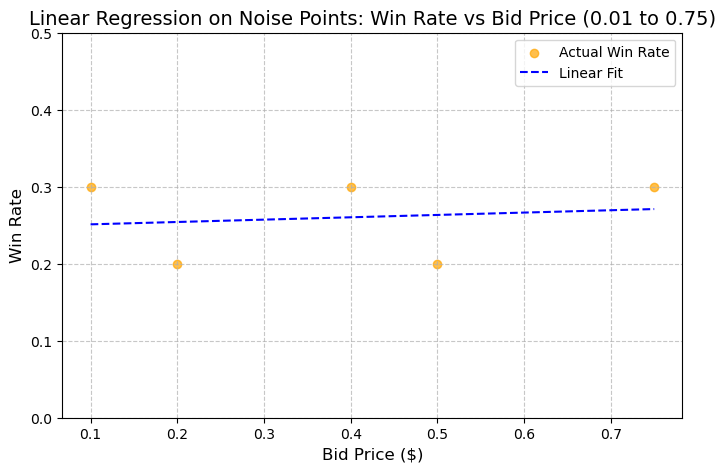

In [17]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data (non-weighted regression)
X = filtered_win_data["bid_price"].values.reshape(-1, 1)
y = filtered_win_data["win_rate"].values

# Fit a simple linear regression model (non-weighted)
model = LinearRegression()
model.fit(X, y)

# Predict using the linear model
y_pred = model.predict(X)
print("Predictions: ",y_pred)

# Plot the non-weighted regression
plt.figure(figsize=(8, 5))
plt.scatter(filtered_win_data["bid_price"], filtered_win_data["win_rate"], color='orange', label='Actual Win Rate', alpha=0.7)
plt.plot(filtered_win_data["bid_price"], y_pred, color='blue', linestyle='--', label='Linear Fit')
plt.title("Linear Regression on Noise Points: Win Rate vs Bid Price (0.01 to 0.75)", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.ylim(0, 0.5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


### Estimated win rates for the each bid price

In [19]:
win_data["estimated_win_rate"] = win_data["win_rate"]

# Step 3: Update estimated_win_rate for bid_price <= 0.75 using y_pred_filtered
win_data.loc[(win_data["bid_price"] <= 0.75) & (win_data["bid_price"] > 0.01), "estimated_win_rate"] = y_pred

combined_data = win_data.loc[win_data["bid_price"] > 0.01].reset_index(drop=True)

combined_data

,app,bid_price,win,events,win_rate,estimated_win_rate
0,A,0.10,1,3000,0.3,0.251145
1,A,0.20,1,2000000,0.2,0.254198
2,A,0.40,1,300000,0.3,0.260305
3,A,0.50,1,20000,0.2,0.263359
4,A,0.75,1,3000,0.3,0.270992
5,A,1.00,1,600,0.6,0.600000
6,A,2.00,1,70,0.7,0.700000
7,A,5.00,1,8,0.8,0.800000
8,A,9.00,1,1,1.0,1.000000


### Plotting the predicted and calculated win rate values vs bid price

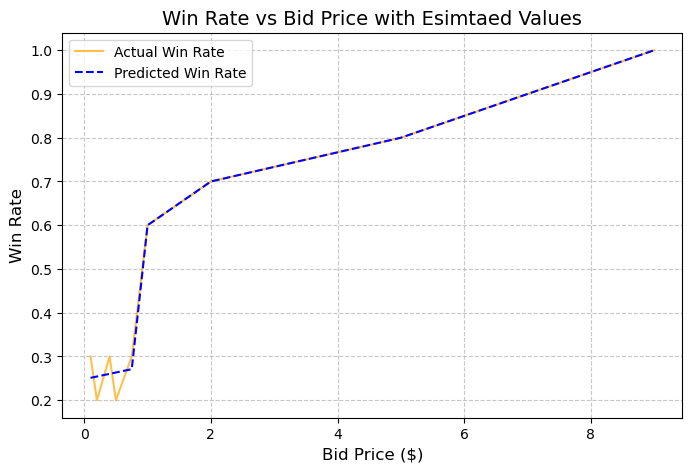

In [20]:
import matplotlib.pyplot as plt

# Plot actual win rates
plt.figure(figsize=(8, 5))
plt.plot(combined_data["bid_price"], combined_data["win_rate"], color='orange', label='Actual Win Rate', alpha=0.7)

# Plot predicted win rates
plt.plot(combined_data["bid_price"], combined_data["estimated_win_rate"], color='blue', linestyle='--', label='Predicted Win Rate')

# Add plot details
plt.title("Win Rate vs Bid Price with Esimtaed Values", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Win Rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


### Problem 2 Assumptions
1. I assume 0.5 is the budget allocated for by the advertiser for each bid, and it remains constant rom the example given with the case study, so I assumed the different auctions were meant for an A/B test.
2. Assumed all other factors like advertiser, advertiser budget, ads placement, slot etc. to be same for all auctions/bid prices.



### Goal

We need to **maximise** the revenue which is equal to **(advertiser_payment_per_win * wins - bid_price * wins)** 

So, we need to **minimize** the experession **bid_price * wins**

Based on the question the expected net revenue is expected revenue per win which can be written as 

**(advertiser_payment_per_win - bid_price) * estimated win rate**

In [54]:
advertiser_payment_per_win = 0.5

#Filtering the data because advertiser_payment_per_win has to be the upper bound for the bid price
df_summary = combined_data[combined_data['bid_price']<=advertiser_payment_per_win]
# Calculate net revenue for each bid price
df_summary["expected_revenue"] = (advertiser_payment_per_win - df_summary["bid_price"]) * df_summary["estimated_win_rate"]
df_summary["net_revenue"] = (advertiser_payment_per_win - df_summary["bid_price"])

# Find the optimal bid price with the highest expected revenue
optimal_row = df_summary.loc[df_summary["expected_revenue"].idxmax()]

# Display the optimal bid price and the associated net revenue
print(f"Calculated initial Optimal Bid Price: {optimal_row['bid_price']:.2f}")
print(f"Net Revenue at Optimal Bid Price: {optimal_row['net_revenue']:.2f}")


Calculated initial Optimal Bid Price: 0.10
Net Revenue at Optimal Bid Price: 0.40


In [55]:
df_summary

,app,bid_price,win,events,win_rate,estimated_win_rate,expected_revenue,net_revenue
0,A,0.1,1,3000,0.3,0.251145,0.100458,0.4
1,A,0.2,1,2000000,0.2,0.254198,0.076260,0.3
2,A,0.4,1,300000,0.3,0.260305,0.026031,0.1
3,A,0.5,1,20000,0.2,0.263359,0.000000,0.0


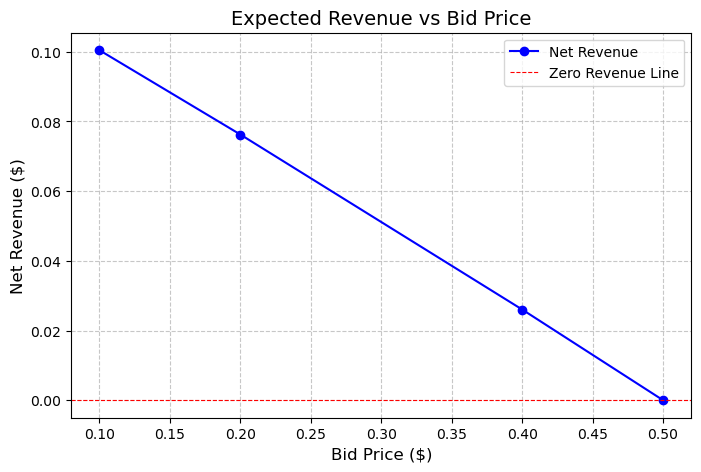

In [56]:
plt.figure(figsize=(8, 5))
plt.plot(df_summary["bid_price"], df_summary["expected_revenue"], color='blue', marker='o', label='Net Revenue')
plt.title("Expected Revenue vs Bid Price", fontsize=14)
plt.xlabel("Bid Price ($)", fontsize=12)
plt.ylabel("Net Revenue ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label="Zero Revenue Line")
plt.legend()
plt.show()

**The curve is going to follow the same trend it'll just shift to the right and the optimal bid price will increase as we increase the advertiser_budget_per_win values.**

**As we observed our estimated win rates follow trends of increasing values so the optimal bid is the one with 0.1 bid price.**

**The optimum bid price value will go down as we descrese the values for advertiser payment per win**